# Setting up a basic ReAct Agent in LangGraph

In [142]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'
os.environ["SERPAPI_API_KEY"] = 's***'  # https://serpapi.com for a free token!

In [2]:
from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])


In [3]:
tools[0].run('Sinan Ozdemir')

'[\'Sinan Ozdemir is a data scientist, start-up founder, and educator living in the San Francisco Bay Area. He studied pure mathematics at the Johns Hopkins University. ...\', \'Sinan Ozdemir type: Author.\', \'Sinan Ozdemir entity_type: people.\', \'Sinan Ozdemir main_tab_text: Overview.\', \'Sinan Ozdemir kgmid: /g/11hcjs9cr6.\', \'Specialized in areas including time management as well as mathematics and computer science logistics.\', \'AI Expert • Author • Entrepreneur. Helping companies leverage AI technology to solve complex problems. Founder, author, and consultant specializing in AI, LLMs, ...\', \'Data Scientist + Author + Entrepreneur. Check out my new book on LLMs on Amazon (Top 10 in AI/NLP). 612 followers · 3 following. LoopGenius.\', "A beginner\'s guide to essential math and coding skills for data fluency and machine learning by Sinan Ozdemir", \'NLP + Gen AI Expert / LLM whisperer. AI Author. Founder @Aikylie (acquired). Contributor on @Forbes. Fellow @YCombinator. San F

# Use [Ollama](https://ollama.com/) for local inference

In [6]:
!python -m pip install -qU langchain-ollama


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [23]:
!ollama pull llama3.1

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 667b0c1932bc... 100% ▕████████████████▏ 4.9 GB                         
pulling 948af2743fc7... 100% ▕████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4... 100% ▕████████████████▏  12 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 455f34728c9b... 100% ▕████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [24]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=1
)
agent_executor = create_react_agent(llm, tools, state_modifier='Today is May 30th, 2025')  # true as of 5/30/2025 ;)

In [25]:
response = agent_executor.invoke({"messages": [("user", "Who is the current Ravens QB?")]})

In [26]:
response['messages'][-1].content

"The current Ravens QB is Lamar Jackson. He has been the team's starting quarterback since 2018 and has led them to several victories, including a Super Bowl championship in 2013 (although he was not the starter for that game)."

In [27]:
# if I didn't put the date in, it would use a past year like 2023 as thr query instead of
#  {"query":"current Baltimore Ravens quarterback 2025"}
for event in agent_executor.stream({"messages": [("user", "Who is the current Ravens QB?")]}):
    print(event)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-05-30T20:54:26.723222Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1539763959, 'load_duration': 14219542, 'prompt_eval_count': 191, 'prompt_eval_duration': 670000000, 'eval_count': 21, 'eval_duration': 851000000, 'model_name': 'llama3.1'}, id='run--29814395-9464-4607-b548-a376e4f303b5-0', tool_calls=[{'name': 'Search', 'args': {'__arg1': 'Current Baltimore Ravens quarterback'}, 'id': '5d31bd99-5d98-4766-9121-d4d4587fdd25', 'type': 'tool_call'}], usage_metadata={'input_tokens': 191, 'output_tokens': 21, 'total_tokens': 212})]}}
{'tools': {'messages': [ToolMessage(content='[\'The Baltimore Ravens are a professional American football team based in Baltimore. The Ravens compete in the National Football League as a member of the American Football Conference North division. The team plays its home games at M&T Bank Stadium and is headquartered in Owings

In [28]:
print(event['agent']['messages'][-1].content)

The current Ravens QB is Lamar Jackson.


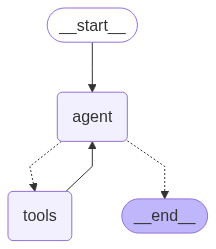

In [29]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [30]:
response = agent_executor.invoke({"messages": [("user", "Who is Sinan Ozdemir?")]})

print(response['messages'][-1].content)

Sinan Ozdemir is a data scientist, start-up founder, educator, and author. He specializes in areas including time management as well as mathematics and computer science logistics. He has written a book on LLMs (Large Language Models) which reached the top 10 in AI/NLP on Amazon.


# Turn our ReAct Agent into a Chat

In [38]:
from langgraph.graph import MessagesState, END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage

In [51]:
class ConvoState(MessagesState):
    # MessagesState already has messages in it
    end: bool

def get_user_input(state):
    user_msg = input("\n🧑 You: ")
    if user_msg.strip().lower() == "exit":
        return {'end': True}
    return {"messages": HumanMessage(content=user_msg)}

def run_agent(state):
    print(f'num of messages: {len(state["messages"])}')
    response = agent_executor.invoke({"messages": state["messages"]})
    print(f"\n🤖 Agent: {response['messages'][-1].content}")
    print(f'num of messages: {len(response['messages'])}')
    return {"messages": response['messages'][len(state['messages']):]}

graph_builder = StateGraph(ConvoState)
graph_builder.add_node("get_user_input", get_user_input)
graph_builder.add_node("run_agent", run_agent)

graph_builder.set_entry_point("get_user_input")
graph_builder.add_conditional_edges(
    "get_user_input", 
    lambda state: 'end' if state.get('end') else 'go',
    {
        'end': END,
        'go': 'run_agent'
    }
)
graph_builder.add_edge("run_agent", "get_user_input")

graph = graph_builder.compile()

In [52]:

print("💬 Start chatting with the agent! Type 'exit' to stop.")
state = graph.invoke({"messages": []})

💬 Start chatting with the agent! Type 'exit' to stop.



🧑 You:  hi


num of messages: 1

🤖 Agent: You said "hi". How can I assist you today?
num of messages: 4



🧑 You:  weather in sf please


num of messages: 5

🤖 Agent: The current weather in San Francisco is partly cloudy with a temperature of 68°F (20°C), humidity of 67%, wind speed of 10 mph, and no precipitation. The forecast for this date shows the same conditions throughout the day. Would you like more information or the weather for another location?
num of messages: 8



🧑 You:  thanks


num of messages: 9

🤖 Agent: You're welcome. Is there anything else I can assist you with?
num of messages: 12



🧑 You:  exit


In [60]:
# Note the bad first tool call even if the transcript itself to the human seemed ok, that's a wasted tool call
for message in state['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        tool_calls = message.additional_kwargs.get('tool_calls')
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    elif hasattr(message, 'tool_calls'):
        tool_calls = message.tool_calls
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["name"]}), Args({tool_call["args"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> hi 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(414bfaeb-f061-467e-a3d5-5f237db3a1b8), Name(Search), Args({'__arg1': 'hi'})
----
<class 'langchain_core.messages.tool.ToolMessage'> {'type': 'dictionary_results', 'syllables': 'hi', 'word_type': 'exclamation'} Tool ID:414bfaeb-f061-467e-a3d5-5f237db3a1b8
----
<class 'langchain_core.messages.ai.AIMessage'> You said "hi". How can I assist you today? 
----
<class 'langchain_core.messages.human.HumanMessage'> weather in sf please 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(27abe48b-c6da-4bb2-b4ab-e2a0b021de62), Name(Search), Args({'__arg1': 'weather in sf'})
----
<class 'langchain_core.messages.tool.ToolMessage'> {'type': 'weather_result', 'temperature': '68', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '67%', 'wind': '10 mph', 'location': 'San Francisco, CA', 'date': 'Friday 2:00 PM', 'weather': 'Partly cloudy'} Tool ID:27abe48b

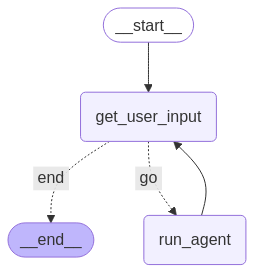

In [86]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))